In [1]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import scipy
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
import viz_explore
import scipy.stats as stats

In [15]:
def split(df, target_var):
    '''
    This function takes in the dataframe and target variable name as arguments and then
    splits the dataframe into train (56%), validate (24%), & test (20%)
    It will return a list containing the following dataframes: train (for exploration), 
    X_train, X_validate, X_test, y_train, y_validate, y_test
    '''
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

    partitions = [train, X_train, X_validate, X_test, y_train, y_validate, y_test]
    return partitions

In [19]:
partitions = [train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test]

In [20]:
partitions = wrangle.split_zillow()

TypeError: split_zillow() missing 1 required positional argument: 'df'

In [2]:
df, train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle.wrangle_zillow()

In [3]:
train_scaled.head()

,parcelid,bathrooms,bedrooms,condition,sq_ft,full_baths,latitude,longitude,lot_size,census_tract,...,tax_amount,logerror,age,sq_ft_per_bathroom,sq_ft_per_bedroom,sq_ft_per_room,has_half_bath,Los_Angeles,Orange,Ventura
0,0.022568,0.333333,0.8,0.454545,0.814802,0.333333,0.388363,0.806060,0.001600,0.296321,...,0.644014,0.596352,0.372263,0.369744,0.133000,0.132159,0.0,0.0,1.0,0.0
1,0.013471,0.333333,0.4,0.454545,0.312370,0.333333,0.377198,0.760380,0.000909,0.005450,...,0.305471,0.595983,0.445255,0.122564,0.091139,0.363787,0.0,1.0,0.0,0.0
2,0.001826,0.333333,0.2,0.636364,0.235233,0.333333,0.616169,0.560645,0.029919,0.000013,...,0.329374,0.596488,0.197080,0.084615,0.125237,0.292418,0.0,1.0,0.0,0.0
3,0.000313,0.000000,0.2,0.454545,0.222377,0.000000,0.549232,0.415546,0.000706,0.009458,...,0.648074,0.603594,0.372263,0.249231,0.118855,0.280523,0.0,1.0,0.0,0.0
4,0.042757,0.666667,0.6,0.454545,0.659138,0.666667,0.635237,0.320844,0.001086,0.999979,...,0.458551,0.595780,0.372263,0.164558,0.141021,0.103487,0.0,0.0,0.0,1.0


In [4]:
# list of variables I will cluster on. 
cluster_vars = ['latitude', 'longitude', 'age']
cluster_name = 'area_cluster'
k_range = range(2,20)


In [5]:
def find_k(X_train_scaled, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

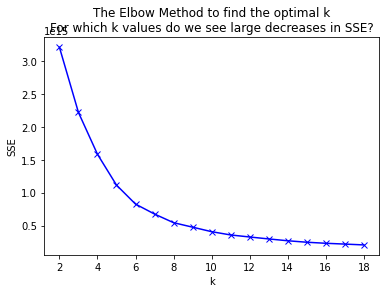

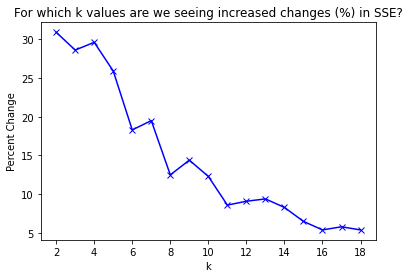

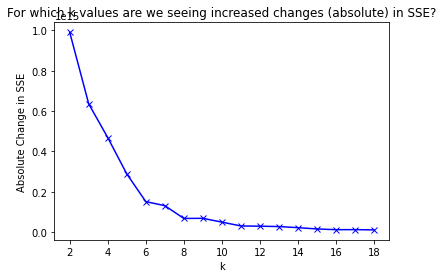

,k,sse,delta,pct_delta
0,2,3.210234e+15,9.910068e+14,30.9
1,3,2.219227e+15,6.357317e+14,28.6
2,4,1.583495e+15,4.688039e+14,29.6
3,5,1.114691e+15,2.887123e+14,25.9
4,6,8.259788e+14,1.514659e+14,18.3
5,7,6.745129e+14,1.313846e+14,19.5
6,8,5.431283e+14,6.806515e+13,12.5
7,9,4.750632e+14,6.862552e+13,14.4
8,10,4.064376e+14,4.981710e+13,12.3
9,11,3.566205e+14,3.077812e+13,8.6


In [6]:
find_k(X_train_scaled, cluster_vars, k_range)

In [7]:
 k = 5
# as reminders: 
cluster_vars = ['latitude', 'longitude', 'age']
cluster_name = 'area_cluster'

In [8]:
def create_clusters(X_train_scaled, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train_scaled[cluster_vars])

    return kmeans

In [9]:
kmeans = create_clusters(X_train_scaled, k, cluster_vars)


In [10]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df

In [11]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)


In [12]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len(X)):
        clusters = pd.DataFrame(kmeans.predict(X[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        X[i] = pd.concat([X[i], clusters_centroids], axis=1)
    return X

In [14]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)


NameError: name 'X' is not defined